In this notebook we will study the energy conservation properties of several high-order methods for the Hénon–Heiles system. We will se how the energy error behaves at very thight tolerances and how different techniques such as using symplectic solvers or manifold projections benchmark against each other.
The Hamiltonian for this system is given by:
$$
\mathcal{H}=\frac{1}{2}(p_1^2 + p_2^2) + \frac{1}{2}\left(q_1^2 + q_2^2 + 2q_1^2 q_2 - \frac{2}{3}q_2^3\right)
$$

We will also compare the in place apporach with the out of place approach by using `Array`s (for the in place version) and `StaticArrays` (for out of place versions). In order to separate these two, we will define the relevant functions and initial conditions in the `InPlace` and `OutofPlace` modules. In this way the rest of the code will work for both.

In [1]:
using DifferentialEquations, Plots
using TaylorIntegration
pyplot()

T(p) = 1//2 * norm(p)^2
V(q) = 1//2 * (q[1]^2 + q[2]^2 + 2q[1]^2 * q[2]- 2//3 * q[2]^3)
H(q, p, params) = T(p) + V(q)

module InPlace
using ParameterizedFunctions

function q̇(dq,q,p,params,t)
    dq[1] = p[1]
    dq[2] = p[2]
end

function ṗ(dp,q,p,params,t)
    dp[1] = -q[1] * (1 + 2q[2])
    dp[2] = -q[2] - (q[1]^2 - q[2]^2)
end

const q0 = [0.1, 0.]
const p0 = [0., 0.5]
const u0 = vcat(q0, p0)

henon = @ode_def HamiltonEqs begin
    dq1 = p1
    dq2 = p2
    dp1 = -q1 * (1 + 2q2)
    dp2 = -q2 - (q1^2 - q2^2)
end

end

module OutOfPlace
using StaticArrays

function q̇(q, p params, t)
    p
end

function ṗ(q, p, params, t)
    dp1 = -q[1] * (1 + 2q[2])
    dp2 = -q[2] - (q[1]^2 - q[2]^2)
    @SVector [dp1, dp2]
end

const q0 = @SVector [0.1, 0.]
const p0 = @SVector [0., 0.5]
const u0 = vcat(q0, p0)

henon(z, p, t) = SVector(
    z[3],
    z[4],
    -z[1] * (1 + 2z[2]), 
    -z[2] - (z[1]^2 - z[2]^2)
)

end

function g(resid, u)
    resid[1] = H([u[1],u[2]],[u[3],u[4]]) - E
    resid[2:4] .= 0
end

const cb = ManifoldProjection(g, nlopts=Dict(:ftol=>1e-13))

const E = H(InPlace.q0, InPlace.p0)

0.13

For the comparison we will use the following function

In [2]:
energy_err(sol) = map(i->H([sol[1,i], sol[2,i]], [sol[3,i], sol[4,i]], nothing)-E, 1:length(sol.u))
abs_energy_err(sol) = [abs.(H([sol[1,j], sol[2,j]], [sol[3,j], sol[4,j]], nothing) - E) for j=1:length(sol.u)]

function compare(mode=InPlace, all=true, plt=nothing; tmax=1e2)
    prob1 = DynamicalODEProblem(mode.q̇, mode.ṗ, mode.q0, mode.p0, (0., tmax))
    prob2 = ODEProblem(mode.henon, mode.u0, (0., tmax))

    gc()
    (mode == InPlace  && all) && @time sol1 = solve(prob2, Vern9(), callback=cb, abstol=1e-14, reltol=1e-14)
    gc()
    @time sol2 = solve(prob1, KahanLi8(), dt=1e-2, maxiters=1e10)
    gc()
    @time sol3 = solve(prob1, SofSpa10(), dt=1e-2, maxiters=1e8)
    gc()
    @time sol4 = solve(prob2, Vern9(), abstol=1e-14, reltol=1e-14)
    gc()
    @time sol5 = solve(prob1, DPRKN12(), abstol=1e-14, reltol=1e-14)
    gc()
    (mode == InPlace && all) && @time sol6 = solve(prob2, TaylorMethod(50), abstol=1e-20)
    
    (mode == InPlace && all) && println("Vern9 + ManifoldProjection max energy error:\t"*
        "$(maximum(abs_energy_err(sol1)))\tin\t$(length(sol1.u))\tsteps.")
    println("KahanLi8 max energy error:\t\t\t$(maximum(abs_energy_err(sol2)))\tin\t$(length(sol2.u))\tsteps.")
    println("SofSpa10 max energy error:\t\t\t$(maximum(abs_energy_err(sol3)))\tin\t$(length(sol3.u))\tsteps.")
    println("Vern9 max energy error:\t\t\t\t$(maximum(abs_energy_err(sol4)))\tin\t$(length(sol4.u))\tsteps.")
    println("DPRKN12 max energy error:\t\t\t$(maximum(abs_energy_err(sol5)))\tin\t$(length(sol5.u))\tsteps.")
    (mode == InPlace && all) && println("TaylorMethod max energy error:\t\t\t$(maximum(abs_energy_err(sol6)))"*
        "\tin\t$(length(sol6.u))\tsteps.")
    
    if plt == nothing
        plt = plot(xlabel="t", ylabel="Energy error")
    end
    (mode == InPlace && all) && plot!(sol1.t, energy_err(sol1), label="Vern9 + ManifoldProjection")
    plot!(sol2.t, energy_err(sol2), label="KahanLi8", ls=mode==InPlace?:solid : :dash)
    plot!(sol3.t, energy_err(sol3), label="SofSpa10", ls=mode==InPlace?:solid : :dash)
    plot!(sol4.t, energy_err(sol4), label="Vern9", ls=mode==InPlace?:solid : :dash)
    plot!(sol5.t, energy_err(sol5), label="DPRKN12", ls=mode==InPlace?:solid : :dash)
    (mode == InPlace && all) && plot!(sol6.t, energy_err(sol6), label="TaylorMethod")
    
    return plt
end

compare (generic function with 4 methods)

The `mode` argument choses between the in place approach
and the out of place one. The `all` parameter is used to compare only the integrators that support both the in place and the out of place versions (we reffer here only to the 6 high order methods chosen bellow).
The `plt` argument can be used to overlay the results over a previous plot and the `tmax` keyword determines the simulation time.

Note: 
1. The `Vern9` method is used with `ODEProblem` because of performance issues with `ArrayPartition` indexing which manifest for `DynamicalODEProblem`.
2. The `NLsolve` call used by `ManifoldProjection` was modified to use `ftol=1e-13` in order to obtain a very low energy error.

Here are the results of the comparisons between the in place methods:

  0.006948 seconds (56.62 k allocations: 8.331 MiB)
  0.010774 seconds (190.21 k allocations: 10.319 MiB)
  0.016848 seconds (190.21 k allocations: 10.319 MiB)
  0.001618 seconds (18.06 k allocations: 1.990 MiB)
  0.000797 seconds (8.55 k allocations: 394.016 KiB)
  0.019648 seconds (173.95 k allocations: 60.718 MiB, 33.75% gc time)
Vern9 + ManifoldProjection max energy error:	5.551115123125783e-16	in	941	steps.
KahanLi8 max energy error:			4.9404924595819466e-15	in	10001	steps.
SofSpa10 max energy error:			5.440092820663267e-15	in	10001	steps.
Vern9 max energy error:				5.551115123125783e-16	in	941	steps.
DPRKN12 max energy error:			2.498001805406602e-16	in	329	steps.
TaylorMethod max energy error:			1.942890293094024e-16	in	80	steps.



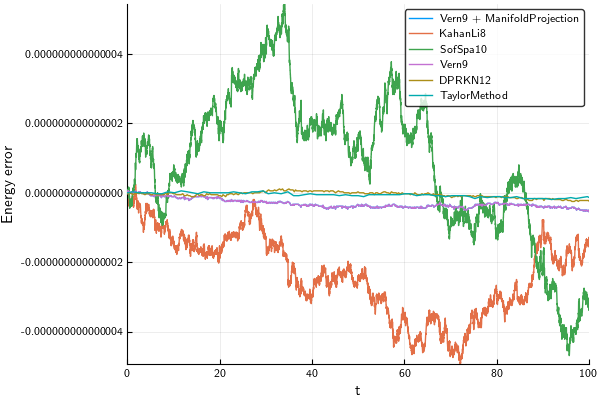

In [4]:
compare(tmax=1e2)

  0.088991 seconds (559.98 k allocations: 82.873 MiB, 24.42% gc time)
  0.252207 seconds (1.90 M allocations: 101.091 MiB, 52.83% gc time)
  0.355502 seconds (1.90 M allocations: 101.091 MiB, 49.34% gc time)
  0.015338 seconds (177.47 k allocations: 19.953 MiB)
  0.005953 seconds (82.21 k allocations: 3.593 MiB)
  0.173109 seconds (1.72 M allocations: 261.793 MiB, 33.59% gc time)
Vern9 + ManifoldProjection max energy error:	5.6066262743570405e-15	in	9330	steps.
KahanLi8 max energy error:			1.815214645262131e-14	in	100002	steps.
SofSpa10 max energy error:			2.8033131371785203e-14	in	100002	steps.
Vern9 max energy error:				5.6066262743570405e-15	in	9330	steps.
DPRKN12 max energy error:			1.0269562977782698e-15	in	3239	steps.
TaylorMethod max energy error:			5.551115123125783e-16	in	784	steps.



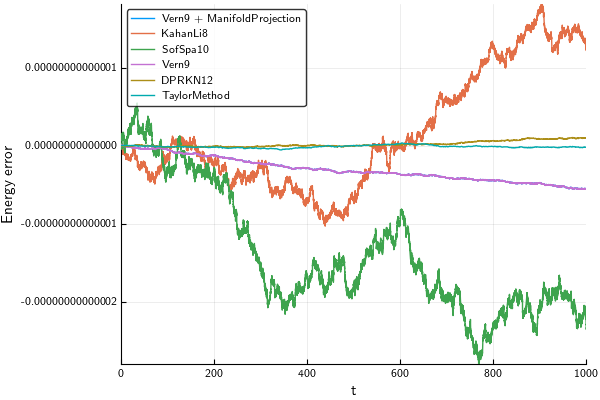

In [5]:
compare(tmax=1e3)

  1.608817 seconds (5.59 M allocations: 825.873 MiB, 58.10% gc time)
  2.587452 seconds (19.00 M allocations: 966.797 MiB, 56.68% gc time)
  5.234921 seconds (19.00 M allocations: 966.798 MiB, 65.82% gc time)
  3.749041 seconds (1.77 M allocations: 197.194 MiB, 96.21% gc time)
  0.077864 seconds (818.97 k allocations: 35.241 MiB, 32.57% gc time)
  3.352294 seconds (17.22 M allocations: 2.220 GiB, 64.92% gc time)
Vern9 + ManifoldProjection max energy error:	4.50195436485501e-14	in	93216	steps.
KahanLi8 max energy error:			3.161360062620133e-14	in	1000001	steps.
SofSpa10 max energy error:			1.136590821460004e-13	in	1000001	steps.
Vern9 max energy error:				4.50195436485501e-14	in	93216	steps.
DPRKN12 max energy error:			1.4988010832439613e-14	in	32348	steps.
TaylorMethod max energy error:			2.7200464103316335e-15	in	7826	steps.



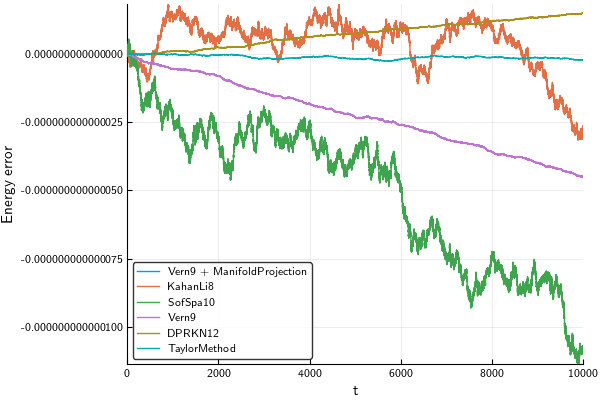

In [6]:
compare(tmax=1e4)

 12.234596 seconds (27.98 M allocations: 4.008 GiB, 71.10% gc time)
 22.346728 seconds (95.00 M allocations: 4.799 GiB, 73.69% gc time)
 48.359011 seconds (95.00 M allocations: 4.799 GiB, 81.13% gc time)
  8.043112 seconds (8.86 M allocations: 965.826 MiB, 88.91% gc time)
 16.441829 seconds (4.10 M allocations: 178.166 MiB, 98.15% gc time)
 13.479651 seconds (86.11 M allocations: 10.950 GiB, 46.69% gc time)
Vern9 + ManifoldProjection max energy error:	9.997558336749535e-14	in	466049	steps.
KahanLi8 max energy error:			1.2331802246023926e-13	in	5000001	steps.
SofSpa10 max energy error:			1.5035195310986182e-13	in	5000001	steps.
Vern9 max energy error:				2.263467191454538e-13	in	466048	steps.
DPRKN12 max energy error:			6.75848266240564e-14	in	161758	steps.
TaylorMethod max energy error:			8.770761894538737e-15	in	39124	steps.



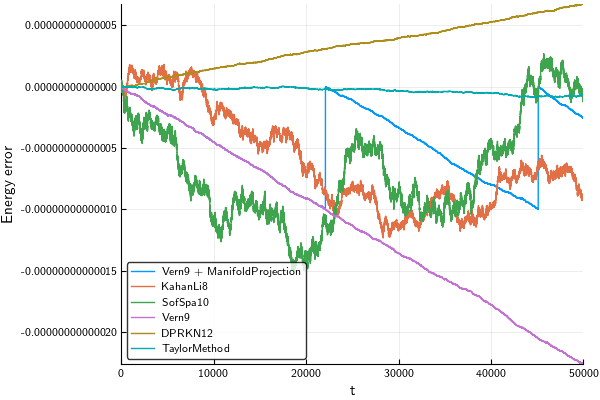

In [7]:
compare(tmax=5e4)

We can see that as the simulation time increases, the energy error increases. For this particular example the energy error for all the methods is comparable. For relatively short simulation times, if a highly accurate solution is required, the symplectic method is not recommended as its energy error fluctuations are larger than for other methods.
An other thing to notice is the fact that the two versions of `Vern9` behave identically, as expected, untill the energy error set by `ftol` is reached.

We will now compare the in place with the out of place versions. In the plots bellow we will use a dashed line for the out of place versions.

In [8]:
function in_vs_out(;all=false, tmax=1e2)
    println("In place versions:")
    plt = compare(InPlace, all, tmax=tmax)
    println("\nOut of place versions:")
    plt = compare(OutOfPlace, false, plt; tmax=tmax)
end

in_vs_out (generic function with 1 method)

First, here is a summary of all the available methods for `tmax = 1e3`:

In place versions:
  0.087090 seconds (559.98 k allocations: 82.873 MiB, 25.09% gc time)
  0.254759 seconds (1.90 M allocations: 101.091 MiB, 51.81% gc time)
  0.368678 seconds (1.90 M allocations: 101.091 MiB, 47.31% gc time)
  0.018539 seconds (177.47 k allocations: 19.953 MiB)
  0.006804 seconds (82.21 k allocations: 3.593 MiB)
  0.191460 seconds (1.72 M allocations: 261.793 MiB, 34.37% gc time)
Vern9 + ManifoldProjection max energy error:	5.6066262743570405e-15	in	9330	steps.
KahanLi8 max energy error:			1.815214645262131e-14	in	100002	steps.
SofSpa10 max energy error:			2.8033131371785203e-14	in	100002	steps.
Vern9 max energy error:				5.6066262743570405e-15	in	9330	steps.
DPRKN12 max energy error:			1.0269562977782698e-15	in	3239	steps.
TaylorMethod max energy error:			5.551115123125783e-16	in	784	steps.

Out of place versions:
  0.068389 seconds (200.20 k allocations: 26.270 MiB, 7.20% gc time)
  0.112746 seconds (200.20 k allocations: 26.271 MiB, 5.19% gc time)
  0.010127 secon


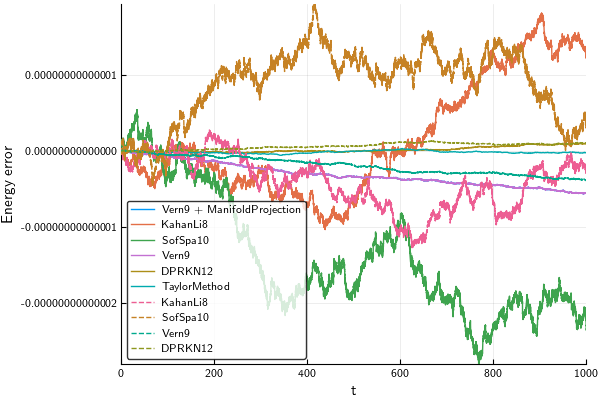

In [10]:
in_vs_out(all=true, tmax=1e3)

Now we will compare the in place and the out of place versions, but only for the integrators that are compatible with `StaticArrays`

In place versions:
  0.011166 seconds (190.21 k allocations: 10.319 MiB)
  0.017026 seconds (190.21 k allocations: 10.319 MiB)
  0.001424 seconds (18.06 k allocations: 1.990 MiB)
  0.000699 seconds (8.55 k allocations: 394.016 KiB)
KahanLi8 max energy error:			4.9404924595819466e-15	in	10001	steps.
SofSpa10 max energy error:			5.440092820663267e-15	in	10001	steps.
Vern9 max energy error:				5.551115123125783e-16	in	941	steps.
DPRKN12 max energy error:			2.498001805406602e-16	in	329	steps.

Out of place versions:
  0.006173 seconds (20.19 k allocations: 3.287 MiB)
  0.011154 seconds (20.19 k allocations: 3.288 MiB)
  0.001102 seconds (2.06 k allocations: 721.266 KiB)
  0.000496 seconds (4.31 k allocations: 241.281 KiB)
KahanLi8 max energy error:			2.7478019859472624e-15	in	10001	steps.
SofSpa10 max energy error:			4.6074255521944e-15	in	10001	steps.
Vern9 max energy error:				5.551115123125783e-16	in	940	steps.
DPRKN12 max energy error:			1.6653345369377348e-16	in	329	steps.



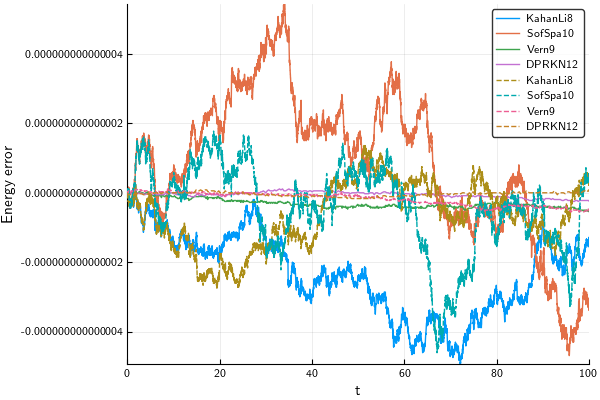

In [11]:
in_vs_out(tmax=1e2)

In place versions:
  0.252757 seconds (1.90 M allocations: 101.091 MiB, 51.43% gc time)
  0.365502 seconds (1.90 M allocations: 101.091 MiB, 47.26% gc time)
  0.017312 seconds (177.47 k allocations: 19.953 MiB)
  0.006477 seconds (82.21 k allocations: 3.593 MiB)
KahanLi8 max energy error:			1.815214645262131e-14	in	100002	steps.
SofSpa10 max energy error:			2.8033131371785203e-14	in	100002	steps.
Vern9 max energy error:				5.6066262743570405e-15	in	9330	steps.
DPRKN12 max energy error:			1.0269562977782698e-15	in	3239	steps.

Out of place versions:
  0.067602 seconds (200.20 k allocations: 26.270 MiB, 7.11% gc time)
  0.112791 seconds (200.20 k allocations: 26.271 MiB, 5.37% gc time)
  0.010464 seconds (18.86 k allocations: 7.467 MiB)
  0.003911 seconds (40.45 k allocations: 2.081 MiB)
KahanLi8 max energy error:			1.2684298056342413e-14	in	100002	steps.
SofSpa10 max energy error:			1.9345636204093353e-14	in	100002	steps.
Vern9 max energy error:				3.885780586188048e-15	in	9330	steps.
D


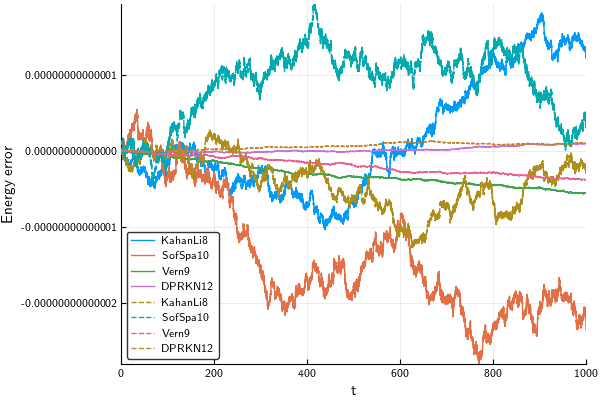

In [12]:
in_vs_out(tmax=1e3)

In place versions:
  2.430788 seconds (19.00 M allocations: 966.797 MiB, 49.21% gc time)
  5.178766 seconds (19.00 M allocations: 966.798 MiB, 62.09% gc time)
  3.577906 seconds (1.77 M allocations: 197.194 MiB, 94.82% gc time)
  0.128713 seconds (818.97 k allocations: 35.241 MiB, 38.71% gc time)
KahanLi8 max energy error:			3.161360062620133e-14	in	1000001	steps.
SofSpa10 max energy error:			1.136590821460004e-13	in	1000001	steps.
Vern9 max energy error:				4.50195436485501e-14	in	93216	steps.
DPRKN12 max energy error:			1.4988010832439613e-14	in	32348	steps.

Out of place versions:
  0.844768 seconds (2.00 M allocations: 208.599 MiB, 26.64% gc time)
  1.526452 seconds (2.00 M allocations: 212.600 MiB, 29.53% gc time)
  0.167141 seconds (186.64 k allocations: 67.917 MiB, 41.14% gc time)
  0.038975 seconds (402.82 k allocations: 19.796 MiB)
KahanLi8 max energy error:			5.5261351050717167e-14	in	1000001	steps.
SofSpa10 max energy error:			2.3342439092743916e-14	in	1000001	steps.
Vern9 m


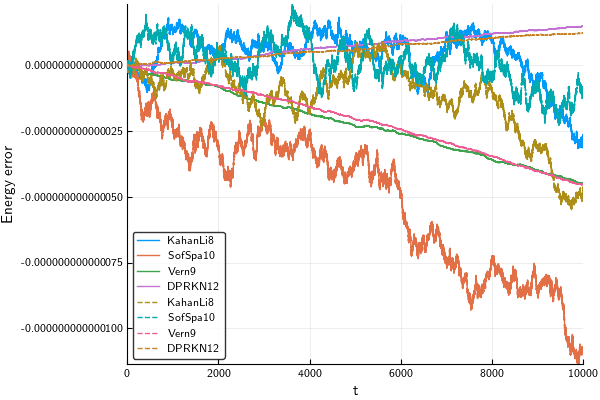

In [13]:
in_vs_out(tmax=1e4)

In place versions:
 19.479835 seconds (95.00 M allocations: 4.799 GiB, 66.75% gc time)
 45.268957 seconds (95.00 M allocations: 4.799 GiB, 79.04% gc time)
  7.956325 seconds (8.86 M allocations: 965.826 MiB, 88.49% gc time)
 15.748986 seconds (4.10 M allocations: 178.166 MiB, 97.64% gc time)
KahanLi8 max energy error:			1.2331802246023926e-13	in	5000001	steps.
SofSpa10 max energy error:			1.5035195310986182e-13	in	5000001	steps.
Vern9 max energy error:				2.263467191454538e-13	in	466048	steps.
DPRKN12 max energy error:			6.75848266240564e-14	in	161758	steps.

Out of place versions:
  3.753265 seconds (10.00 M allocations: 1.183 GiB, 16.54% gc time)
  7.070005 seconds (10.00 M allocations: 1.186 GiB, 24.04% gc time)
  1.708000 seconds (932.31 k allocations: 316.476 MiB, 71.22% gc time)
  0.881038 seconds (2.01 M allocations: 99.415 MiB, 77.42% gc time)
KahanLi8 max energy error:			9.178768856088482e-14	in	5000001	steps.
SofSpa10 max energy error:			1.1290968160437842e-13	in	5000001	step


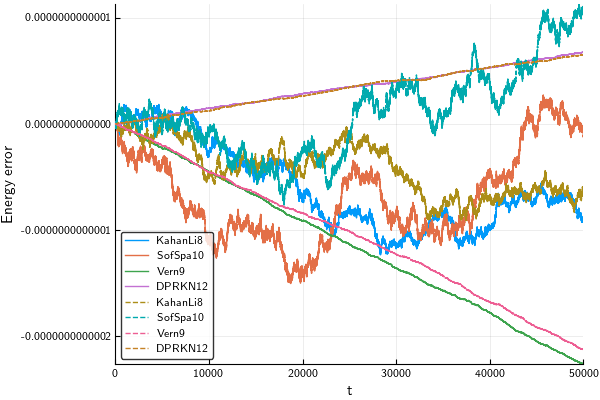

In [14]:
in_vs_out(tmax=5e4)

As we see from the above comparisons, the `StaticArray` versions are significantly faster and use less memory. The speedup provided for the out of place version is more proeminent at larger values for `tmax`.
We can see again that if the simulation time is increased, the energy error of the symplectic methods is less noticeable compared to the rest of the methods.

The benchmarks were performed on a machine with

In [15]:
versioninfo()

Julia Version 0.6.2
Commit d386e40c17 (2017-12-13 18:08 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-4720HQ CPU @ 2.60GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, haswell)
